In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# read survey
data_dictionary = pd.read_csv('data_dictionary.csv')
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# read aggregated actigraphy
actigraphy_data = pd.read_csv('PA_data.csv', index_col=0)

In [3]:
# Outliers ----------------------------------------------------------------------------
# removing outliers (should change this to be automatic so it applies to the test data)
# From CGAS
train_data.loc[2065, 'CGAS-CGAS_Score'] = 99
# From BIA (there might still be some suspicious extreme values)
cols = data_dictionary.loc[(data_dictionary['Instrument'] == 'Bio-electric Impedance Analysis') & (data_dictionary['Type'] == 'float'), 'Field']
train_data.loc[[3205, 3511], cols] = np.nan # remove 3511 and 3205's BIA values because they seem wrong. They have normal heights and weights but extreme values for BIA measures

# Drop features ----------------------------------------------------------------------
# combine FitnessGram Minutes and seconds
train_data['Fitness_Endurance-Total_Time_sec'] = train_data['Fitness_Endurance-Time_Mins'] * 60 + train_data['Fitness_Endurance-Time_Sec'] # remove remaining Fitness_Endurance Columns
# drop all PCIAT columns, any column that ends in -Season, FitnessGram Zones, remaining Fitness_Endurance columns, and redundant SDS column
columns_to_drop = [col for col in train_data.columns if col.startswith('PCIAT') or col.endswith('Season') or col.endswith('Zone')]
columns_to_drop.extend(['Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Sec', 'Fitness_Endurance-Time_Mins', 'SDS-SDS_Total_Raw'])
train_data_cleaned = train_data.drop(columns=columns_to_drop)

# merge PAQ_A and PAQ_C
# keep adolescent value if 13 or older
train_data_cleaned.loc[train_data_cleaned['PAQ_A-PAQ_A_Total'].notna() & train_data_cleaned['PAQ_C-PAQ_C_Total'].notna() & (train_data_cleaned['Basic_Demos-Age'] >= 13), 'PAQ_C-PAQ_C_Total'] = np.nan
# keep child value is younger than 13
train_data_cleaned.loc[train_data_cleaned['PAQ_A-PAQ_A_Total'].notna() & train_data_cleaned['PAQ_C-PAQ_C_Total'].notna() & (train_data_cleaned['Basic_Demos-Age'] < 13), 'PAQ_A-PAQ_A_Total'] = np.nan
# merge columns
train_data_cleaned['PAQ-PAQ_Total'] = train_data_cleaned['PAQ_A-PAQ_A_Total'].fillna(train_data_cleaned['PAQ_C-PAQ_C_Total'])
# drop columns
train_data_cleaned = train_data_cleaned.drop(columns = ['PAQ_A-PAQ_A_Total', 'PAQ_C-PAQ_C_Total'])

# include aggregate acitgraphy features
train_data_cleaned = pd.merge(train_data_cleaned, actigraphy_data, left_on='id', how='left', right_index=True)

# Missing Values (might not have to handle completely manually for CATBoost, though it could improve performance) -----------
# Drop rows with high missingness (should investigate characteristics of rows with high missingness)
thresh = 50
percent_missing_per_row = train_data_cleaned.isnull().mean(axis=1) * 100
high_missingness_idx = percent_missing_per_row[percent_missing_per_row > thresh].index.values
train_data_cleaned = train_data_cleaned.drop(high_missingness_idx)
print(f'{len(high_missingness_idx)} rows dropped because {thresh}% or more of the data was missing.')
print(f'There are {len(train_data_cleaned)} rows remaining in the train data.')

# Drop features with high missingness?
print('This is the proportion of data available per feature. It might be wise to drop features with high missingness. We can try both ways though.')
display(train_data_cleaned.notna().mean().sort_values())

# Impute/interpolate remaining missing values (not necessary for CATBoost)

# Convert categorical columns to the correct data type? Since their ordinal, it might work to not convert
# use data dictionary to convert features that have type=="categorical int" into str dtype

# drop rows without target
train_data_cleaned = train_data_cleaned.dropna(subset='sii')
print(f'Final length of the training dataset: {len(train_data_cleaned)}')

1863 rows dropped because 50% or more of the data was missing.
There are 2097 rows remaining in the train data.
This is the proportion of data available per feature. It might be wise to drop features with high missingness. We can try both ways though.


Physical-Waist_Circumference              0.249881
Fitness_Endurance-Total_Time_sec          0.311874
vigorous                                  0.384835
moderate                                  0.395327
light                                     0.395804
sendentary                                0.395804
FGC-FGC_GSND                              0.405341
FGC-FGC_GSD                               0.405818
PAQ-PAQ_Total                             0.646161
CGAS-CGAS_Score                           0.820219
SDS-SDS_Total_T                           0.842632
FGC-FGC_PU                                0.855508
FGC-FGC_SRL                               0.855508
FGC-FGC_SRR                               0.856462
FGC-FGC_CU                                0.859323
FGC-FGC_TL                                0.859800
sii                                       0.919409
BIA-BIA_SMM                               0.944206
BIA-BIA_LST                               0.944206
BIA-BIA_LDM                    

Final length of the training dataset: 1928


## Voting with Hyperopt Regressor

In [43]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import train_test_split
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from sklearn.metrics import mean_squared_error
import numpy as np


X = train_data_cleaned.drop(columns=['sii','sii_class'])
y = train_data_cleaned['sii']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_columns = train_data_cleaned.select_dtypes(include=['object']).columns.tolist()


for col in categorical_columns:
    X_train[col] = X_train[col].astype(str)
    X_val[col] = X_val[col].astype(str)

print(f"Categorical columns in train_data_cleaned: {categorical_columns}")
print(f"Columns in X_train: {X_train.columns.tolist()}")


def optimize_catboost(params):
    model = CatBoostRegressor(
        iterations=int(params['iterations']),
        depth=int(params['depth']),
        learning_rate=params['learning_rate'],
        cat_features=categorical_columns,
        verbose=0
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    return {'loss': rmse, 'status': STATUS_OK}

def optimize_xgboost(params):
    model = XGBRegressor(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        objective='reg:squarederror',
        verbosity=0
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    return {'loss': rmse, 'status': STATUS_OK}

def optimize_lightgbm(params):
    model = LGBMRegressor(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate']
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    return {'loss': rmse, 'status': STATUS_OK}


catboost_space = {
    'iterations': hp.quniform('iterations', 100, 500, 50),
    'depth': hp.quniform('depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3)
}

xgboost_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3)
}

lightgbm_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3)
}


print("Optimizing CatBoost...")
catboost_trials = Trials()
catboost_best = fmin(fn=optimize_catboost, space=catboost_space, algo=tpe.suggest, max_evals=10, trials=catboost_trials)

print("Optimizing XGBoost...")
xgboost_trials = Trials()
xgboost_best = fmin(fn=optimize_xgboost, space=xgboost_space, algo=tpe.suggest, max_evals=10, trials=xgboost_trials)

print("Optimizing LightGBM...")
lightgbm_trials = Trials()
lightgbm_best = fmin(fn=optimize_lightgbm, space=lightgbm_space, algo=tpe.suggest, max_evals=10, trials=lightgbm_trials)

catboost_best = {k: int(v) if k != 'learning_rate' else v for k, v in catboost_best.items()}
xgboost_best = {k: int(v) if k != 'learning_rate' else v for k, v in xgboost_best.items()}
lightgbm_best = {k: int(v) if k != 'learning_rate' else v for k, v in lightgbm_best.items()}


catboost_model = CatBoostRegressor(**catboost_best, verbose=0)
xgboost_model = XGBRegressor(**xgboost_best, objective='reg:squarederror')
lightgbm_model = LGBMRegressor(**lightgbm_best)

catboost_model.fit(X_train, y_train)
xgboost_model.fit(X_train, y_train)
lightgbm_model.fit(X_train, y_train)


voting_model = VotingRegressor(estimators=[
    ('catboost', catboost_model),
    ('xgboost', xgboost_model),
    ('lightgbm', lightgbm_model)
])

voting_model.fit(X_train, y_train)
y_pred_voting = voting_model.predict(X_val)


rmse_voting = mean_squared_error(y_val, y_pred_voting, squared=False)
print(f'Voting Regressor RMSE: {rmse_voting}')


Categorical columns in train_data_cleaned: ['id']
Columns in X_train: ['id', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday', 'Fitness_Endurance-Total_Time_sec', 'PAQ-PAQ_Total', 'sendentary', 'light', 'moderate', 'vigorous']
Optimizing CatBoost...
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

 10%|█         | 1/10 [00:49<07:23, 49.31s/trial, best loss: 0.6917593789519615]

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 20%|██        | 2/10 [01:14<04:40, 35.07s/trial, best loss: 0.6917593789519615]

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 30%|███       | 3/10 [01:57<04:30, 38.59s/trial, best loss: 0.6896145191327555]

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 40%|████      | 4/10 [02:13<02:58, 29.79s/trial, best loss: 0.6896145191327555]

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 50%|█████     | 5/10 [02:57<02:54, 34.82s/trial, best loss: 0.6886809131072075]

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 60%|██████    | 6/10 [03:05<01:42, 25.69s/trial, best loss: 0.6886809131072075]

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 70%|███████   | 7/10 [03:13<01:00, 20.06s/trial, best loss: 0.6886809131072075]

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 80%|████████  | 8/10 [03:44<00:46, 23.46s/trial, best loss: 0.6886809131072075]

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 90%|█████████ | 9/10 [04:09<00:24, 24.09s/trial, best loss: 0.6886809131072075]

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



100%|██████████| 10/10 [05:29<00:00, 32.90s/trial, best loss: 0.6886809131072075]
Optimizing XGBoost...
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

job exception: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:id: object



  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:id: object

In [44]:

X_train = X_train.select_dtypes(include=['number', 'category'])
X_val = X_val.select_dtypes(include=['number', 'category'])


for col in categorical_columns:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
        X_val[col] = X_val[col].astype('category')


def optimize_xgboost(params):
    model = XGBRegressor(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        objective='reg:squarederror',
        enable_categorical=True  
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    return {'loss': rmse, 'status': STATUS_OK}


print("Optimizing XGBoost...")
xgboost_trials = Trials()
xgboost_best = fmin(fn=optimize_xgboost, space=xgboost_space, algo=tpe.suggest, max_evals=10, trials=xgboost_trials)


Optimizing XGBoost...
 10%|█         | 1/10 [00:01<00:12,  1.40s/trial, best loss: 0.7184705167273004]

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 20%|██        | 2/10 [00:02<00:10,  1.29s/trial, best loss: 0.7184705167273004]

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 30%|███       | 3/10 [00:03<00:08,  1.21s/trial, best loss: 0.7184705167273004]

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 40%|████      | 4/10 [00:05<00:08,  1.41s/trial, best loss: 0.7184705167273004]

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 50%|█████     | 5/10 [00:06<00:05,  1.16s/trial, best loss: 0.7184705167273004]

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 60%|██████    | 6/10 [00:08<00:05,  1.43s/trial, best loss: 0.710863757037171] 

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 70%|███████   | 7/10 [00:09<00:04,  1.36s/trial, best loss: 0.710863757037171]

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 80%|████████  | 8/10 [00:10<00:02,  1.32s/trial, best loss: 0.699922739676027]

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



 90%|█████████ | 9/10 [00:11<00:01,  1.20s/trial, best loss: 0.699922739676027]

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



100%|██████████| 10/10 [00:12<00:00,  1.24s/trial, best loss: 0.699922739676027]


c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



In [45]:
print("Optimizing LightGBM...")
lightgbm_trials = Trials()
lightgbm_best = fmin(fn=optimize_lightgbm, space=lightgbm_space, algo=tpe.suggest, max_evals=10, trials=lightgbm_trials)


Optimizing LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6500                     
[LightGBM] [Info] Number of data points in the train set: 1542, number of used features: 41
[LightGBM] [Info] Start training from score 0.584306  
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No furt

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further sp

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further sp

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf      
[LightGBM] [Warning] No further sp

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with p

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with p

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf     
[LightGBM] [Warning] No further splits with p

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    
[LightGBM] [Warning] No further splits with positive gai

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf    
[LightGBM] [Warning] No further splits with positive gai

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



In [46]:

catboost_best = {k: int(v) if k != 'learning_rate' else v for k, v in catboost_best.items()}
xgboost_best = {k: int(v) if k != 'learning_rate' else v for k, v in xgboost_best.items()}
lightgbm_best = {k: int(v) if k != 'learning_rate' else v for k, v in lightgbm_best.items()}


catboost_model = CatBoostRegressor(**catboost_best, verbose=0)
xgboost_model = XGBRegressor(**xgboost_best, objective='reg:squarederror')
lightgbm_model = LGBMRegressor(**lightgbm_best)

catboost_model.fit(X_train, y_train)
xgboost_model.fit(X_train, y_train)
lightgbm_model.fit(X_train, y_train)

voting_model = VotingRegressor(estimators=[
    ('catboost', catboost_model),
    ('xgboost', xgboost_model),
    ('lightgbm', lightgbm_model)
])

voting_model.fit(X_train, y_train)
y_pred_voting = voting_model.predict(X_val)


rmse_voting = mean_squared_error(y_val, y_pred_voting, squared=False)
print(f'Voting Regressor RMSE: {rmse_voting}')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6500
[LightGBM] [Info] Number of data points in the train set: 1542, number of used features: 41
[LightGBM] [Info] Start training from score 0.584306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Squared Error (MSE): 0.4547
Root Mean Squared Error (RMSE): 0.6743
Mean Absolute Error (MAE): 0.5250
R² Score: 0.2459


c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


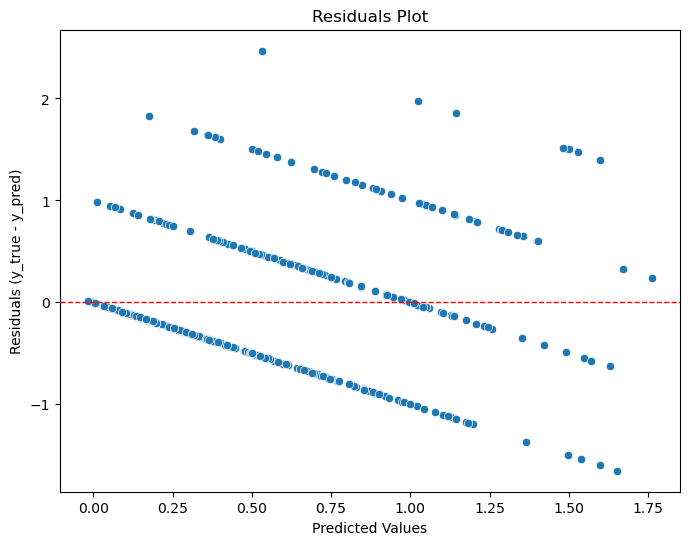

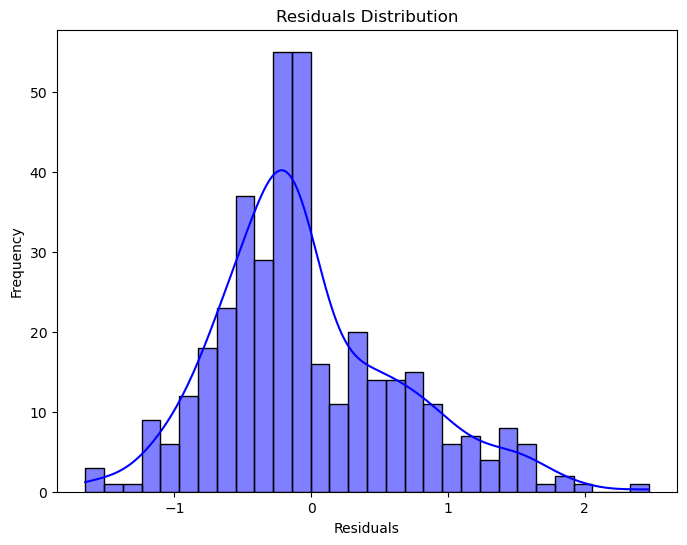

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


y_pred = voting_model.predict(X_val)


mse = mean_squared_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred, squared=False)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)


print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

residuals = y_val - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residuals Plot")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (y_true - y_pred)")
plt.show()


plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.title("Residuals Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()


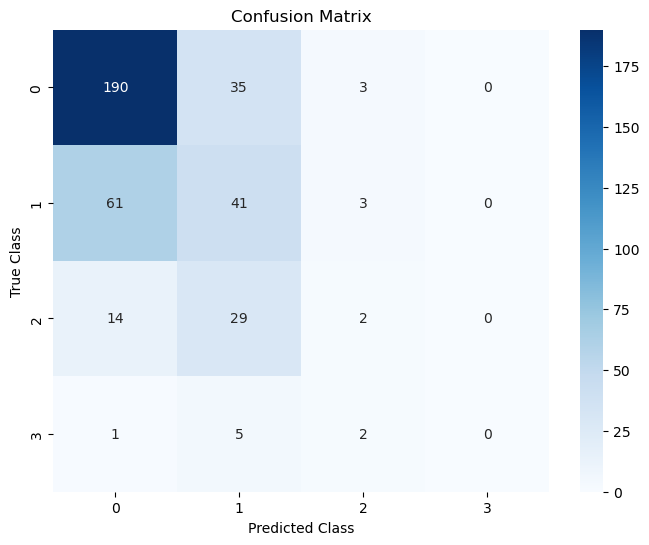

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.71      0.83      0.77       228
     Class 1       0.37      0.39      0.38       105
     Class 2       0.20      0.04      0.07        45
     Class 3       0.00      0.00      0.00         8

    accuracy                           0.60       386
   macro avg       0.32      0.32      0.31       386
weighted avg       0.55      0.60      0.57       386



c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\shaun\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [48]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

num_classes = 4
bins = np.linspace(y_val.min(), y_val.max(), num_classes + 1)  
y_val_class = np.digitize(y_val, bins[:-1], right=True) - 1  
y_pred_class = np.digitize(y_pred, bins[:-1], right=True) - 1


y_val_class = np.clip(y_val_class, 0, num_classes - 1)
y_pred_class = np.clip(y_pred_class, 0, num_classes - 1)

conf_matrix = confusion_matrix(y_val_class, y_pred_class, labels=range(num_classes))


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

print("Classification Report:")
print(classification_report(y_val_class, y_pred_class, target_names=[f"Class {i}" for i in range(num_classes)]))


In [49]:
from sklearn.metrics import cohen_kappa_score
import numpy as np


true_labels_kappa = y_val  
predicted_labels_kappa = y_pred


bins = np.arange(-0.5, 4.5, 1) 
predicted_labels_binned = np.digitize(predicted_labels_kappa, bins) - 1  


weighted_kappa = cohen_kappa_score(true_labels_kappa, predicted_labels_binned, weights='quadratic')

print(f"Weighted Kappa (Quadratic): {weighted_kappa:.4f}")


Weighted Kappa (Quadratic): 0.3909


# Here we switch to Classification

In [29]:
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


X = train_data_cleaned.drop(columns=['sii', 'id', 'sii_class'], errors='ignore')  
y = train_data_cleaned['sii']


print("Unique values in y (sii):", y.unique())  


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()


for col in categorical_columns:
    X_train[col] = X_train[col].astype('category')
    X_val[col] = X_val[col].astype('category')


print("Features in X_train:", X_train.columns.tolist())
print("Categorical columns:", categorical_columns)


def optimize_catboost(params):
    model = CatBoostClassifier(
        iterations=int(params['iterations']),
        depth=int(params['depth']),
        learning_rate=params['learning_rate'],
        cat_features=categorical_columns,
        verbose=0
    )
    model.fit(X_train, y_train)
    accuracy = model.score(X_val, y_val)
    return {'loss': -accuracy, 'status': STATUS_OK}

def optimize_xgboost(params):
    model = XGBClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        use_label_encoder=False,
        enable_categorical=True,
        objective='multi:softmax'
    )
    model.fit(X_train, y_train)
    accuracy = model.score(X_val, y_val)
    return {'loss': -accuracy, 'status': STATUS_OK}

def optimize_lightgbm(params):
    model = LGBMClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate']
    )
    model.fit(X_train, y_train)
    accuracy = model.score(X_val, y_val)
    return {'loss': -accuracy, 'status': STATUS_OK}


catboost_space = {
    'iterations': hp.quniform('iterations', 100, 500, 50),
    'depth': hp.quniform('depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3)
}

xgboost_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3)
}

lightgbm_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 50),
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3)
}


Unique values in y (sii): [2. 0. 1. 3.]
Features in X_train: ['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_SRL', 'FGC-FGC_SRR', 'FGC-FGC_TL', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'SDS-SDS_Total_T', 'PreInt_EduHx-computerinternet_hoursday', 'Fitness_Endurance-Total_Time_sec', 'PAQ-PAQ_Total', 'sendentary', 'light', 'moderate', 'vigorous']
Categorical columns: []


In [30]:


print("Optimizing CatBoost...")
catboost_trials = Trials()
catboost_best = fmin(fn=optimize_catboost, space=catboost_space, algo=tpe.suggest, max_evals=10, trials=catboost_trials)



Optimizing CatBoost...
100%|██████████| 10/10 [01:10<00:00,  7.04s/trial, best loss: -0.616580310880829]


In [31]:
print("Optimizing XGBoost...")
xgboost_trials = Trials()
xgboost_best = fmin(fn=optimize_xgboost, space=xgboost_space, algo=tpe.suggest, max_evals=10, trials=xgboost_trials)



Optimizing XGBoost...
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

c:\Users\shaun\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:19:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 10%|█         | 1/10 [00:01<00:16,  1.80s/trial, best loss: -0.5854922279792746]

c:\Users\shaun\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:19:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 20%|██        | 2/10 [00:04<00:18,  2.34s/trial, best loss: -0.5854922279792746]

c:\Users\shaun\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:19:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 30%|███       | 3/10 [00:05<00:12,  1.84s/trial, best loss: -0.5854922279792746]

c:\Users\shaun\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:19:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 40%|████      | 4/10 [00:07<00:11,  1.88s/trial, best loss: -0.5932642487046632]

c:\Users\shaun\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:19:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 50%|█████     | 5/10 [00:09<00:08,  1.74s/trial, best loss: -0.5958549222797928]

c:\Users\shaun\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:19:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 60%|██████    | 6/10 [00:09<00:04,  1.25s/trial, best loss: -0.6010362694300518]

c:\Users\shaun\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:19:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 70%|███████   | 7/10 [00:11<00:04,  1.34s/trial, best loss: -0.6010362694300518]

c:\Users\shaun\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:19:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 80%|████████  | 8/10 [00:12<00:02,  1.40s/trial, best loss: -0.6010362694300518]

c:\Users\shaun\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:19:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



 90%|█████████ | 9/10 [00:14<00:01,  1.52s/trial, best loss: -0.6010362694300518]

c:\Users\shaun\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:19:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



100%|██████████| 10/10 [00:16<00:00,  1.60s/trial, best loss: -0.6010362694300518]


In [32]:
print("Optimizing LightGBM...")
lightgbm_trials = Trials()
lightgbm_best = fmin(fn=optimize_lightgbm, space=lightgbm_space, algo=tpe.suggest, max_evals=10, trials=lightgbm_trials)




Optimizing LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6500                     
[LightGBM] [Info] Number of data points in the train set: 1542, number of used features: 41
[LightGBM] [Info] Start training from score -0.544012 
[LightGBM] [Info] Start training from score -1.322242 
[LightGBM] [Info] Start training from score -1.956340 
[LightGBM] [Info] Start training from score -4.450464 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

Optimized XGBoost parameters: {'learning_rate': 0.017133105960247454, 'max_depth': 3, 'n_estimators': 100}
Optimized LightGBM parameters: {'learning_rate': 0.15888760323964699, 'max_depth': 9, 'n_estimators': 400}


c:\Users\shaun\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:25:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6500
[LightGBM] [Info] Number of data points in the train set: 1542, number of used features: 41
[LightGBM] [Info] Start training from score -0.544012
[LightGBM] [Info] Start training from score -1.322242
[LightGBM] [Info] Start training from score -1.956340
[LightGBM] [Info] Start training from score -4.450464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

c:\Users\shaun\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:26:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6500
[LightGBM] [Info] Number of data points in the train set: 1542, number of used features: 41
[LightGBM] [Info] Start training from score -0.544012
[LightGBM] [Info] Start training from score -1.322242
[LightGBM] [Info] Start training from score -1.956340
[LightGBM] [Info] Start training from score -4.450464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

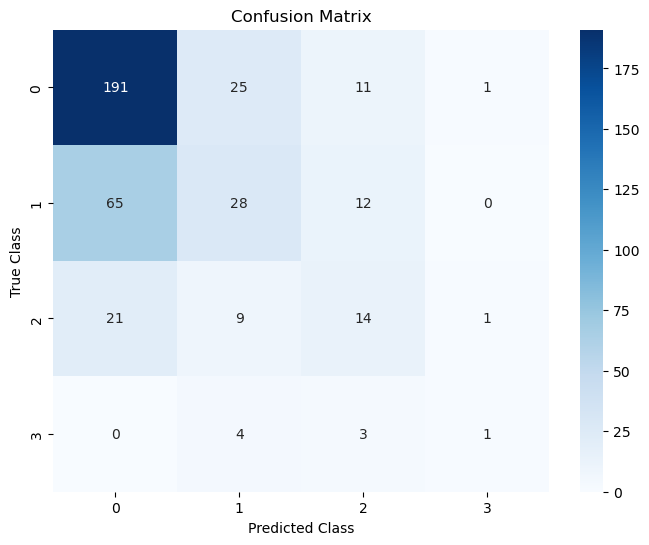

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.69      0.84      0.76       228
     Class 1       0.42      0.27      0.33       105
     Class 2       0.35      0.31      0.33        45
     Class 3       0.33      0.12      0.18         8

    accuracy                           0.61       386
   macro avg       0.45      0.39      0.40       386
weighted avg       0.57      0.61      0.58       386



In [33]:

catboost_model = CatBoostClassifier(**catboost_best, verbose=0, cat_features=categorical_columns)

lightgbm_model = LGBMClassifier(**lightgbm_best)

xgboost_best = {key: int(value) if key in ['n_estimators', 'max_depth'] else value for key, value in xgboost_best.items()}


print("Optimized XGBoost parameters:", xgboost_best)


xgboost_model = XGBClassifier(
    **xgboost_best,
    use_label_encoder=False,
    enable_categorical=True,
    objective='multi:softmax'
)

lightgbm_best = {key: int(value) if key in ['n_estimators', 'max_depth'] else value for key, value in lightgbm_best.items()}

print("Optimized LightGBM parameters:", lightgbm_best)


lightgbm_model = LGBMClassifier(**lightgbm_best)


catboost_model.fit(X_train, y_train)
xgboost_model.fit(X_train, y_train)
lightgbm_model.fit(X_train, y_train)


voting_model = VotingClassifier(estimators=[
    ('catboost', catboost_model),
    ('xgboost', xgboost_model),
    ('lightgbm', lightgbm_model)
], voting='soft')

voting_model.fit(X_train, y_train)
y_pred = voting_model.predict(X_val)


conf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(4), yticklabels=range(4))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=[f"Class {i}" for i in range(4)]))

In [36]:
from sklearn.metrics import cohen_kappa_score
import numpy as np


true_labels_kappa = y_val 
predicted_labels_kappa = y_pred


bins = np.arange(-0.5, 4.5, 1) 
predicted_labels_binned = np.digitize(predicted_labels_kappa, bins) - 1  


weighted_kappa = cohen_kappa_score(true_labels_kappa, predicted_labels_binned, weights='quadratic')

print(f"Weighted Kappa (Quadratic): {weighted_kappa:.4f}")


Weighted Kappa (Quadratic): 0.3827


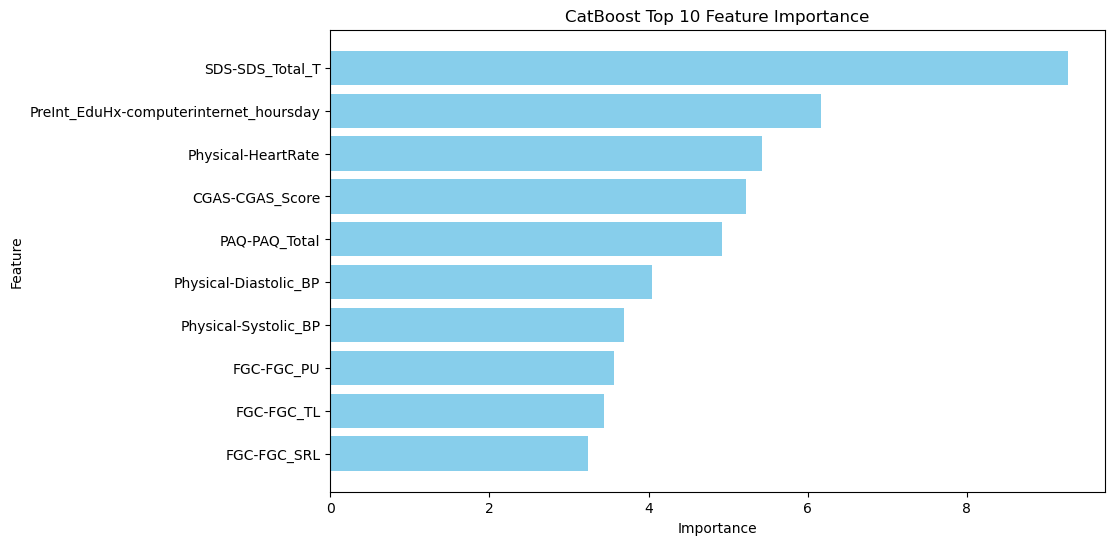


CatBoost Top 10 Features:
                                   Feature  Importance
33                         SDS-SDS_Total_T    9.273517
34  PreInt_EduHx-computerinternet_hoursday    6.170391
8                       Physical-HeartRate    5.424602
2                          CGAS-CGAS_Score    5.219763
36                           PAQ-PAQ_Total    4.926774
7                    Physical-Diastolic_BP    4.045774
9                     Physical-Systolic_BP    3.693429
13                              FGC-FGC_PU    3.565209
16                              FGC-FGC_TL    3.446849
14                             FGC-FGC_SRL    3.240954


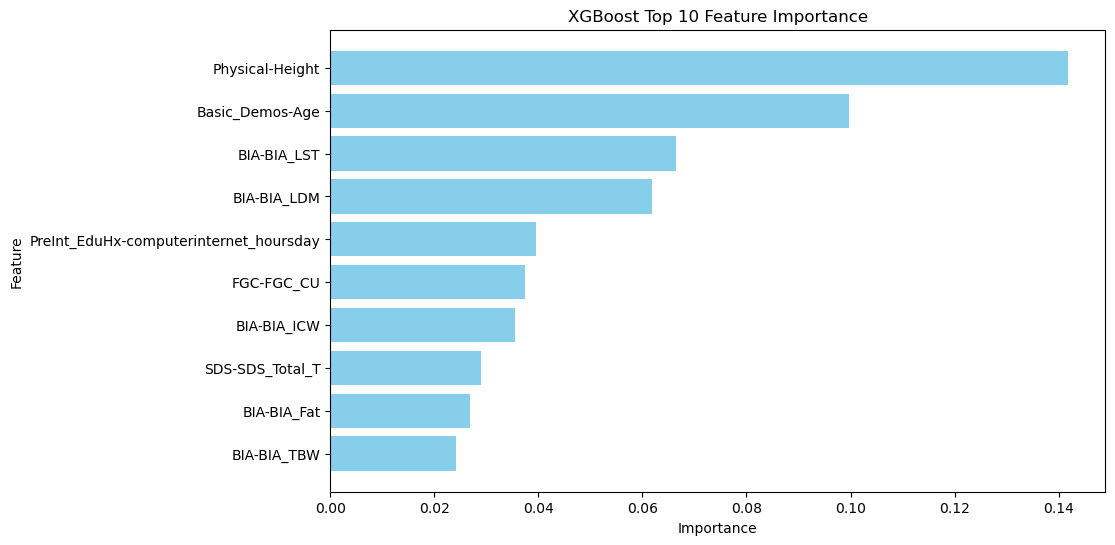


XGBoost Top 10 Features:
                                   Feature  Importance
4                          Physical-Height    0.141826
0                          Basic_Demos-Age    0.099742
30                             BIA-BIA_LST    0.066413
29                             BIA-BIA_LDM    0.061862
34  PreInt_EduHx-computerinternet_hoursday    0.039545
10                              FGC-FGC_CU    0.037385
28                             BIA-BIA_ICW    0.035442
33                         SDS-SDS_Total_T    0.029037
26                             BIA-BIA_Fat    0.026834
32                             BIA-BIA_TBW    0.024260


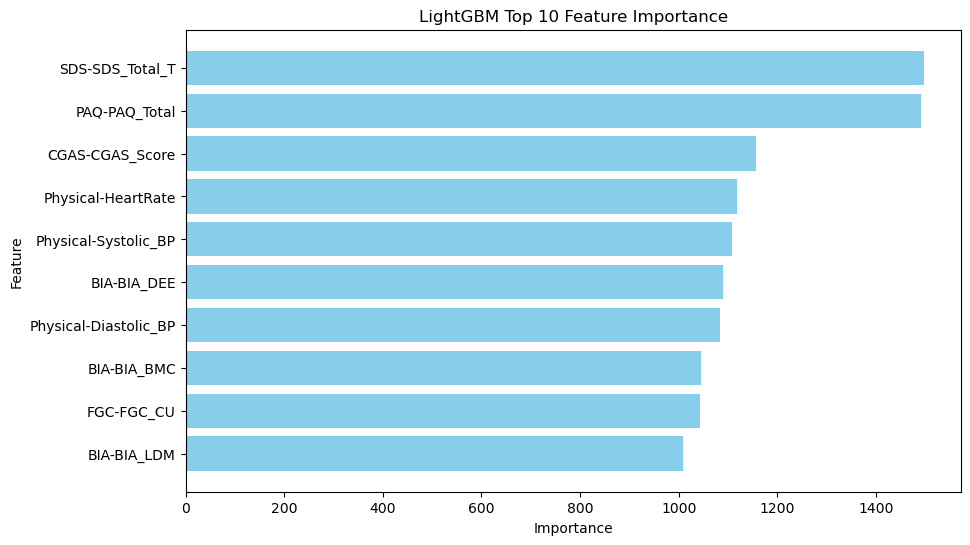


LightGBM Top 10 Features:
                  Feature  Importance
33        SDS-SDS_Total_T        1497
36          PAQ-PAQ_Total        1492
2         CGAS-CGAS_Score        1156
8      Physical-HeartRate        1119
9    Physical-Systolic_BP        1108
21            BIA-BIA_DEE        1089
7   Physical-Diastolic_BP        1083
18            BIA-BIA_BMC        1045
10             FGC-FGC_CU        1043
29            BIA-BIA_LDM        1009


In [35]:
import matplotlib.pyplot as plt


def plot_top_features(feature_importances, feature_names, title="Top 10 Feature Importance"):
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False).head(10)  
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.title(title)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.gca().invert_yaxis()
    plt.show()
    return importance_df


feature_names = X_train.columns


catboost_importance = catboost_model.get_feature_importance()
catboost_top10 = plot_top_features(catboost_importance, feature_names, title="CatBoost Top 10 Feature Importance")
print("\nCatBoost Top 10 Features:")
print(catboost_top10)


xgboost_importance = xgboost_model.feature_importances_
xgboost_top10 = plot_top_features(xgboost_importance, feature_names, title="XGBoost Top 10 Feature Importance")
print("\nXGBoost Top 10 Features:")
print(xgboost_top10)


lightgbm_importance = lightgbm_model.feature_importances_
lightgbm_top10 = plot_top_features(lightgbm_importance, feature_names, title="LightGBM Top 10 Feature Importance")
print("\nLightGBM Top 10 Features:")
print(lightgbm_top10)
